# Data Preprocessing and Library loading:

In [10]:
import json, sys, time, os, copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas
import pickle

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")
fullDataset = False

In [11]:
jsonDir = "./jsonFiles"
numpyDir = "./numpyFiles"

fullTestSet = np.load(os.path.join(numpyDir,"fullTestSet.npy"))
errMSE = np.load(os.path.join(numpyDir,"ERROR_MAE_3D_T1.npy"))

with open(os.path.join(jsonDir,"file_list_3D_MAE.json"),"r") as f:
    fileList = json.load(f)

fileList = [x[:-8] for x in fileList]

print("Number of Files: ", len(fileList))

Number of Files:  31199


In [12]:
# Flattening Error volume 8x7x7 for RF

errFlat = np.zeros((errMSE.shape[0],errMSE.shape[1]*errMSE.shape[2]*errMSE.shape[3]))

for i in range(errMSE.shape[0]):
    errFlat[i] = errMSE[i,:,:,:].flatten()

print("Pre Flatten {} vs. Flattened {}".format(errMSE.shape,errFlat.shape))

Pre Flatten (31199, 8, 7, 7) vs. Flattened (31199, 392)


In [13]:
# Load in tags and additional meta data:

with open(os.path.join(jsonDir,"./reasons_split.json"),"r") as f: # Tags
    tagDict = json.load(f)

if not fullDataset:
    with open(os.path.join(jsonDir,"biobank_meta_float.json"),"r") as f: # Float meta data from dcm headers
        metaDict = json.load(f)
else:
    with open(os.path.join(jsonDir,"biobank_meta_full_one_hot.json"),"r") as f: # All one hot encoded meta
        metaDict = json.load(f)

with open(os.path.join(jsonDir,"Biobank_Bounding_Boxes.json"),"r") as f: # Bounding box meta data
    bBoxes = json.load(f)

In [14]:
# Sort through subj to make sure all meta data present

if fullDataset:
    keys = list(metaDict['eid'].values())
else:
    keys = list(metaDict.keys())

keys = [k for k in keys if k in bBoxes.keys()]
keys = [k for k in keys if k in fileList]

print("Number of Files with complete meta data: ", len(keys))

Number of Files with complete meta data:  31199


In [15]:
###### Find out the keys present in every single case:
if not fullDataset:
    allMetaKeys = []
    instTime = ["1","2","3","4","5","6","7"]
    for k in keys:
        for i in instTime:
            allMetaKeys.extend(list(metaDict[k][i].keys()))

    allMetaKeysSet = set(allMetaKeys)

    keysOI = []
    for k in allMetaKeysSet:
        if allMetaKeys.count(k) == (len(keys)*7):
            keysOI.append(k)
else:
    keysOI = list(metaDict.keys())

print("Meta values to use: \n\n", keysOI)

Meta values to use: 

 ['[SliceResolution]', 'Rows', '[CSA Series Header Version]', 'Study Date', 'Window Width', 'Number of Averages', 'Inversion Time', 'Repetition Time', 'Instance Creation Date', 'Acquisition Date', 'Echo Time', 'Imaging Frequency', "Patient's Size", 'Samples per Pixel', 'Window Center', 'SAR', 'Bits Allocated', 'Columns', '[SliceMeasurementDuration]', 'Bits Stored', 'Content Time', 'High Bit', 'Pixel Bandwidth', 'Percent Phase Field of View', 'Series Time', 'Series Number', 'Series Date', 'Echo Train Length', "Patient's Weight", 'Smallest Image Pixel Value', 'Instance Creation Time', 'dB/dt', 'Slice Location', 'Percent Sampling', "Patient's Birth Date", 'Magnetic Field Strength', '[RealDwellTime]', 'Acquisition Number', 'Device Serial Number', '[TimeAfterStart]', 'Echo Number(s)', 'Slice Thickness', '[CSA Image Header Version]', 'Flip Angle', 'Largest Image Pixel Value', 'Study Time', '[CSA Image Header Version ??]', 'Number of Phase Encoding Steps', 'Pixel Represe

In [16]:

# Create dataset (full one hot):
if fullDataset:
    subjLength = len(keys)
    dataLength = len(keysOI)
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            metaList.append(metaDict[kOI][str(i)])

        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

# Create dataset (float only):
else:
    subjLength = len(keys)
    dataLength = len(keysOI)*len(instTime)
    print("Data Length: {}\n".format(dataLength))
    bBoxesLength = 16
    errLength = errFlat.shape[1]

    ownDataset = np.zeros((subjLength,dataLength + bBoxesLength + errLength))

    k0 = list(tagDict.keys())[0]
    tags = np.zeros((subjLength,len(tagDict[k0])))

    for i,k in enumerate(keys):
        sys.stdout.write("\r[{}/{}]".format(i,len(keys)))
        metaList = []
        for kOI in keysOI:
            for inst in instTime:
                metaList.append(metaDict[k][inst][kOI])
        try:
            metaList.extend(bBoxes[k]["Body"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Liver"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Lungs"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        try:
            metaList.extend(bBoxes[k]["Heart"])
        except KeyError as e:
            metaList.extend([0,0,0,0])

        charArr = np.char.find(fileList,k)
        charIdx = np.argwhere(charArr == 0)[0,0]
        
        assert(type(charIdx) == np.int64)
        errMeta = list(errFlat[charIdx,:])

        metaList.extend(errMeta)

        ownDataset[i,:] = np.array(metaList)
        if k in tagDict.keys():
            tags[i] = np.array(tagDict[k])

    ownDataset = (ownDataset,tags)

    print("\n Meta Data for Subj0: {} \n Tag for Subj0: {}".format(ownDataset[0][0][:10],ownDataset[1][0]))

Data Length: 364

[31198/31199]
 Meta Data for Subj0: [  1.   1.   1.   1.   1.   1.   1. 288. 288. 288.] 
 Tag for Subj0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
print("Header Meta Data: {} \nBounding Box Meta Data: {} \nImage Recon Errors: {} \n".format(dataLength,bBoxesLength,errLength))

Header Meta Data: 364 
Bounding Box Meta Data: 16 
Image Recon Errors: 392 



# Train Random Forests:

## All Data:

In [18]:
# Hyperparameters:

testSize = 0.5
n_estimators = 100
max_depth = 10
tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
numAvgs = np.arange(0,20,1)


In [19]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [20]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.734186     0.999610         0.848246        0.806442   
std     0.007972     0.000037         0.005153        0.013325   
min     0.723028     0.999543         0.836805        0.773862   
25%     0.728008     0.999590         0.846444        0.796344   
50%     0.734360     0.999613         0.847566        0.809234   
75%     0.738353     0.999642         0.852025        0.816047   
max     0.751930     0.999658         0.859588        0.826294   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.782288   0.922317        0.901069   0.816923   0.910036   
std           0.026900   0.002321        0.003934   0.008850   0.002729   
min           0.739983   0.917922        0.892977   0.793538   0.906639   
25%           0.771547   0.921

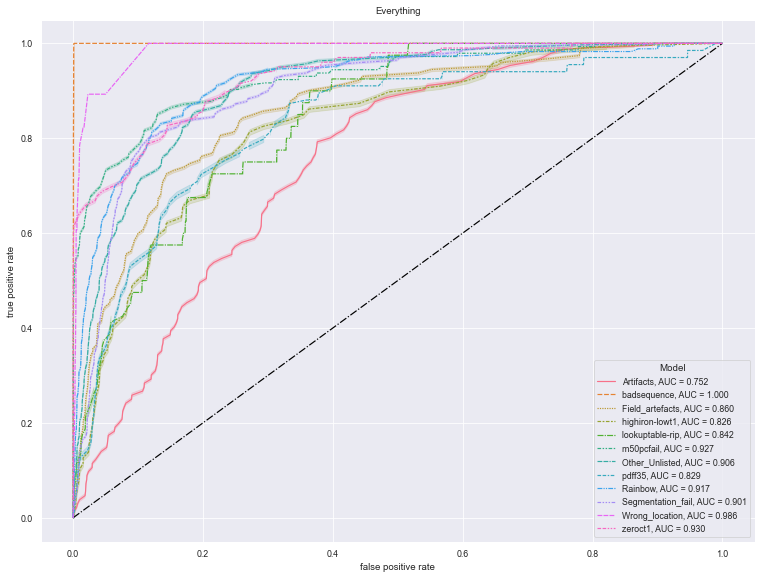

In [21]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Everything")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [22]:
# Save Models
saveDir = "./models/Random Forests/All_Meta/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta + Bboxes:

In [23]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-errLength]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [24]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.612133     0.999667         0.806825        0.538774   
std     0.013417     0.000029         0.004854        0.015734   
min     0.585316     0.999619         0.798154        0.494186   
25%     0.603567     0.999647         0.803561        0.534173   
50%     0.613387     0.999662         0.806317        0.542695   
75%     0.623694     0.999692         0.808136        0.549144   
max     0.632264     0.999724         0.817210        0.554694   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.711886   0.714100        0.657185   0.738317   0.879956   
std           0.018129   0.006448        0.012910   0.012146   0.005143   
min           0.676919   0.707437        0.631974   0.706717   0.867641   
25%           0.702094   0.708

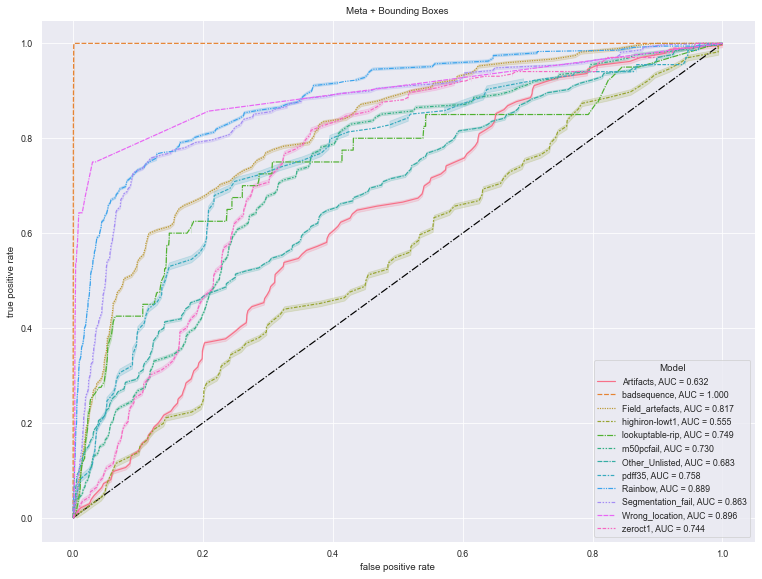

In [25]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [26]:
# Save Models
saveDir = "./models/Random Forests/Meta_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Meta Only:

In [27]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,:-(bBoxesLength+errLength)]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [28]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.594165     0.999691         0.793817        0.522356   
std     0.013994     0.000023         0.006342        0.016480   
min     0.570529     0.999641         0.781106        0.493585   
25%     0.586056     0.999679         0.789638        0.516288   
50%     0.592567     0.999690         0.794711        0.520951   
75%     0.603080     0.999710         0.798181        0.532542   
max     0.628886     0.999737         0.802680        0.554648   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.716926   0.686130        0.620587   0.705642   0.869295   
std           0.022098   0.006460        0.010831   0.010612   0.005916   
min           0.667760   0.674972        0.602291   0.680270   0.856729   
25%           0.701804   0.684

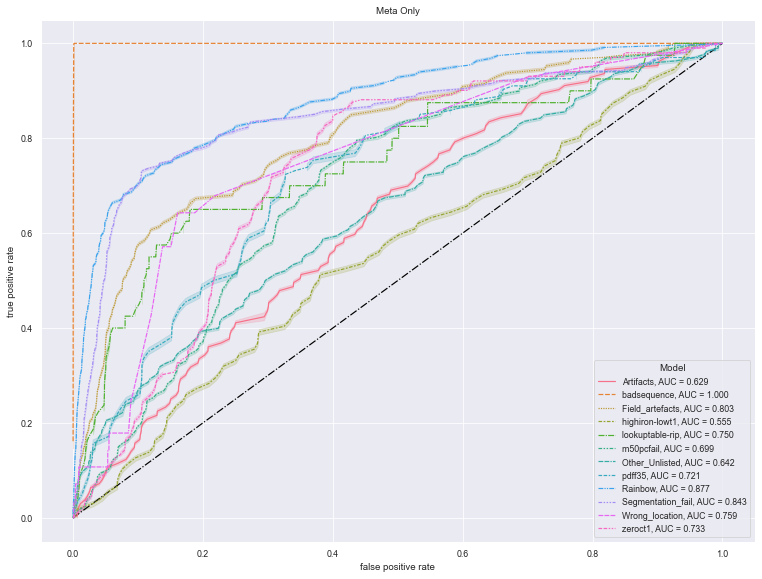

In [29]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Meta Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [30]:
# Save Models
saveDir = "./models/Random Forests/Meta_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error Only: 

In [31]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-errLength:]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [32]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.737104     0.998291         0.851315        0.842191   
std     0.006938     0.000054         0.007285        0.013205   
min     0.726173     0.998219         0.830076        0.817404   
25%     0.731827     0.998242         0.847651        0.834553   
50%     0.736651     0.998290         0.854308        0.842458   
75%     0.741584     0.998320         0.855943        0.849235   
max     0.749487     0.998441         0.859792        0.874083   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.797491   0.914753        0.904812   0.833491   0.900543   
std           0.024399   0.003813        0.004463   0.015811   0.002868   
min           0.732923   0.909069        0.897010   0.808250   0.894035   
25%           0.784046   0.912

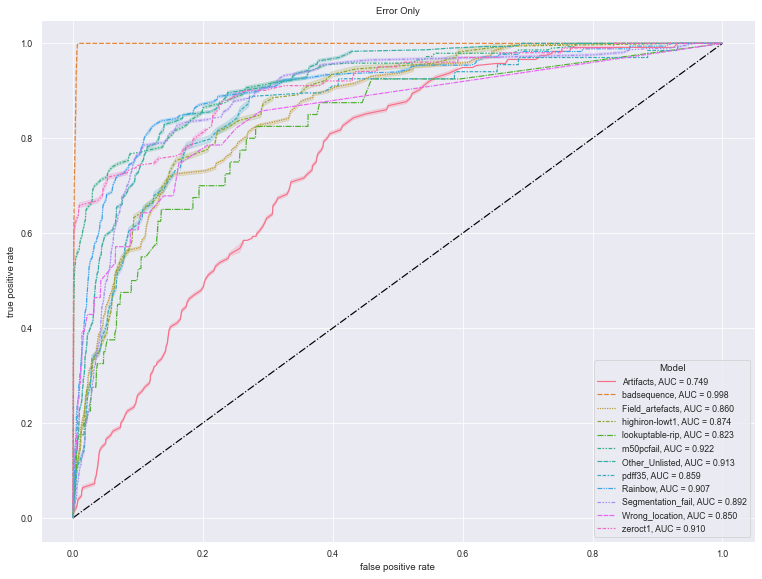

In [33]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error Only")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [34]:
# Save Models
saveDir = "./models/Random Forests/Error_Only/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

## Error + BBoxes:

In [35]:
x0, y0 = ownDataset

metricsDict = {}
clfDict = {}

topAUC = {}
avgAUC = {}
for name in tagNames:
    topAUC[name] = 0.0
    metricsDict[name] = {}
    avgAUC[name] = []

for nAv in numAvgs:
    for idx,name in enumerate(tagNames):
        sys.stdout.write("\r[{}/{}]".format(nAv*len(tagNames)+idx,numAvgs.shape[0]*len(tagNames)))
        clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,verbose=False,n_jobs=-1)

        y = y0[:,idx]
        X = x0[:,-(bBoxesLength+errLength):]

        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=testSize,random_state=42)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        probs = clf.predict_proba(X_test)

        fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
        auc_score = roc_auc_score(y_test,probs[:,1])

        avgAUC[name].append(auc_score)

        if topAUC[name] < auc_score:
            topAUC[name] = auc_score
            clfDict[name] = clf

            metricsDict[name]["AUC"] = auc_score
            metricsDict[name]["FPR"] = fpr
            metricsDict[name]["TPR"] = tpr

[239/240]

In [36]:
# Format for Seaborn

modelsArr = []
fprArr = []
tprArr = []

for name in tagNames:
    auc_score = metricsDict[name]["AUC"]
    fpr = metricsDict[name]["FPR"]
    tpr = metricsDict[name]["TPR"]

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})
df2 = pandas.DataFrame(avgAUC)
print(df2.describe())

print("#"*50)

tempDict = {"Name":tagNames,"Max AUC":[metricsDict[name]["AUC"] for name in tagNames],"Avg AUC":[np.mean(avgAUC[name]) for name in tagNames]}

df3 = pandas.DataFrame(tempDict)
print(df3)

       Artifacts  badsequence  Field_artefacts  highiron-lowt1  \
count  20.000000    20.000000        20.000000       20.000000   
mean    0.739642     0.998763         0.850091        0.845669   
std     0.011585     0.000062         0.004830        0.011075   
min     0.722136     0.998647         0.842432        0.816172   
25%     0.730198     0.998736         0.846100        0.839845   
50%     0.739083     0.998767         0.849919        0.845898   
75%     0.746446     0.998803         0.854305        0.854187   
max     0.763406     0.998880         0.858496        0.864296   

       lookuptable-rip  m50pcfail  Other_Unlisted     pdff35    Rainbow  \
count        20.000000  20.000000       20.000000  20.000000  20.000000   
mean          0.806800   0.917283        0.910511   0.834615   0.906017   
std           0.018868   0.003269        0.004109   0.008609   0.004455   
min           0.767189   0.912286        0.902045   0.819007   0.898010   
25%           0.794886   0.915

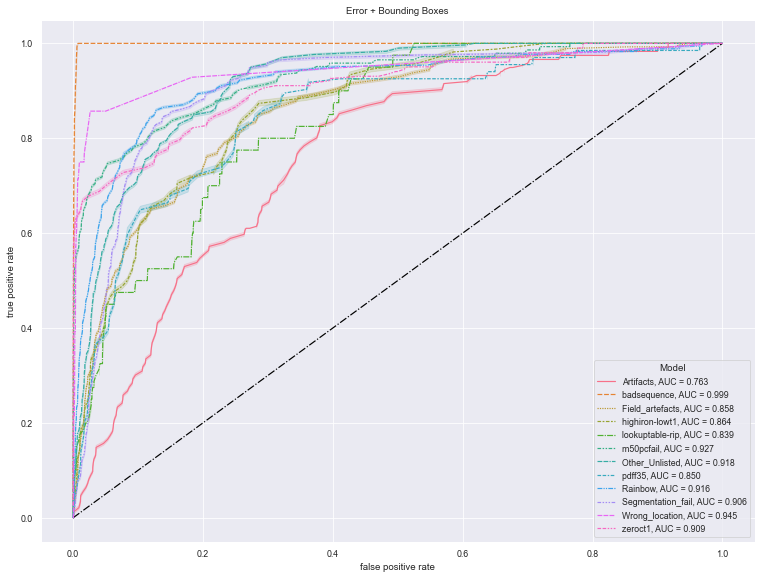

In [37]:
# Plot the ROC curves for each Class (One Vs Rest)

plt.figure()
plt.title("Error + Bounding Boxes")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

In [38]:
# Save Models
saveDir = "./models/Random Forests/Error_BBoxes/"

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

for name in tagNames:
    if not os.path.isdir(os.path.join(saveDir,name)):
        os.mkdir(os.path.join(saveDir,name))
    pickle.dump(clfDict[name], open(os.path.join(saveDir,name,"classifier.sav"),'wb'))

df2.to_excel(os.path.join(saveDir,"metrics.xlsx"))
df2.to_json(os.path.join(saveDir,"metrics.json"))

df.to_excel(os.path.join(saveDir,"roc_values.xlsx"))
df.to_json(os.path.join(saveDir,"roc_values.json"))

# AUC Comparisons:

                   All_Meta  Error_BBoxes  Error_Only  Meta_BBoxes  Meta_Only
Artifacts          0.734186      0.739642    0.737104     0.612133   0.594165
badsequence        0.999610      0.998763    0.998291     0.999667   0.999691
Field_artefacts    0.848246      0.850091    0.851315     0.806825   0.793817
highiron-lowt1     0.806442      0.845669    0.842191     0.538774   0.522356
lookuptable-rip    0.782288      0.806800    0.797491     0.711886   0.716926
m50pcfail          0.922317      0.917283    0.914753     0.714100   0.686130
Other_Unlisted     0.901069      0.910511    0.904812     0.657185   0.620587
pdff35             0.816923      0.834615    0.833491     0.738317   0.705642
Rainbow            0.910036      0.906017    0.900543     0.879956   0.869295
Segmentation_fail  0.890968      0.891053    0.886178     0.851418   0.832569
Wrong_location     0.914660      0.910666    0.794853     0.859817   0.585638
zeroct1            0.920859      0.898084    0.895755     0.7229

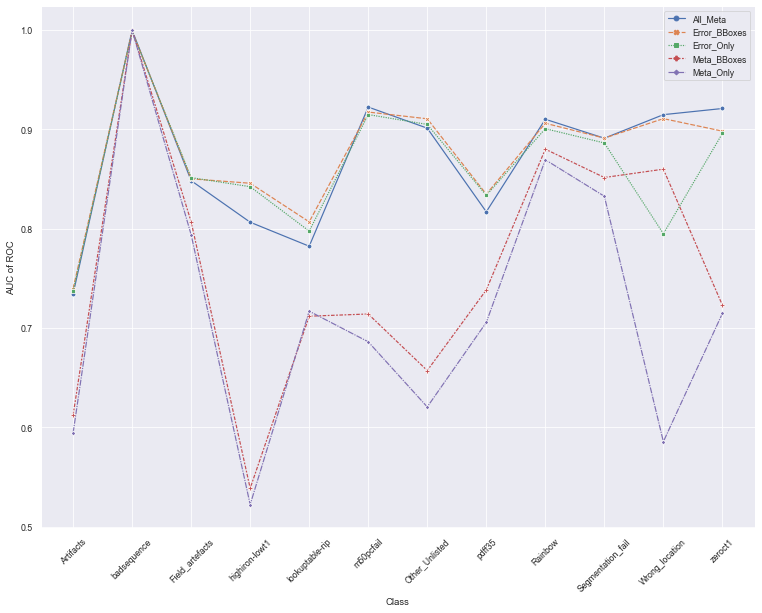

In [39]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

loadDir = "./models/Random Forests/"

ignoreList = ["Float","Float_Categorical"]
rfList = [x for x in os.listdir(loadDir) if x not in ignoreList]

fullDict = {}
for fol in rfList:
    fullDict[fol] = {}
    with open(os.path.join(loadDir,fol,"metrics.json")) as f:
        metrics = json.load(f)
    for k1 in metrics.keys():
        avgAUC = []
        for k2 in metrics[k1].keys():
            avgAUC.append(metrics[k1][k2])
        fullDict[fol][k1] = np.mean(avgAUC)

df = pd.DataFrame(fullDict)
print(df)

plt.figure()
sns.lineplot(data=df,markers=True)
plt.xlabel("Class")
plt.ylabel("AUC of ROC")
plt.xticks(rotation=45)
plt.show()

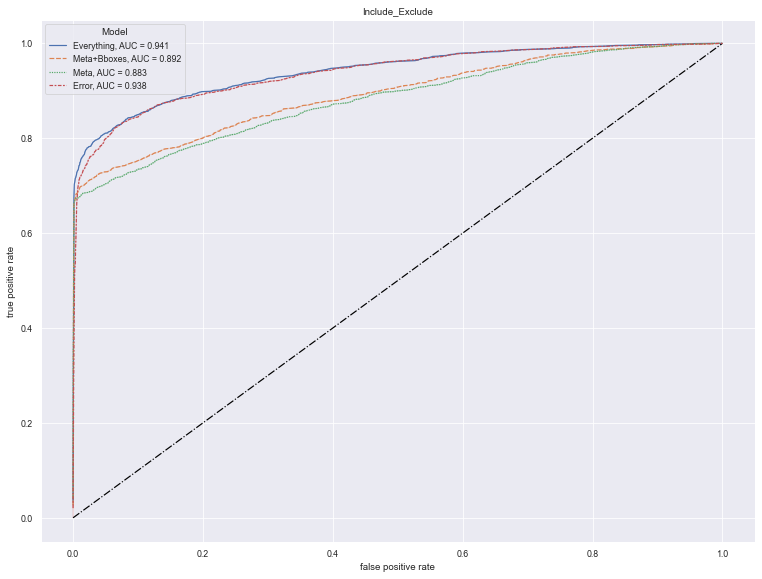

In [40]:
x0, y0 = ownDataset

newY = np.zeros(y0.shape[0])
for i in range(y0.shape[0]):
    if np.sum(y0[i,:]) >= 1:
        newY[i] = 1

y0 = newY

modelsArr = []
fprArr = []
tprArr = []
clfDict = {}

names = ["Everything","Meta+Bboxes","Meta","Error"]
features = [(0,-1),(0,-errFlat.shape[1]),(0,-(16+errFlat.shape[1])),(-errFlat.shape[1],-1)]

for name,(m,n) in zip(names,features):
    clf = RandomForestClassifier(n_estimators=100,max_depth=10,verbose=False,n_jobs=-1)

    y = y0
    if n == -1:
        X = x0[:,m:]
    else:
        X = x0[:,m:n]

    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.4,random_state=42)

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    probs = clf.predict_proba(X_test)

    fpr,tpr,thresh = roc_curve(y_test,probs[:,1])
    auc_score = roc_auc_score(y_test,probs[:,1])

    event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

    clfDict[name] = clf

    modelsArr.extend(event)
    fprArr.extend(fpr)
    tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)

df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Include_Exclude")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model")
plt.show()

# Feature Importance:

In [41]:

featuresPlot = {}
for name in tagNames:
    featuresPlot[name] = []

for idx,name in enumerate(tagNames):
    print("#"*50)
    print(name)
    print("#"*50)

    clf = clfDict[name]
    instCnt = 0
    featCnt = -1
    for i,fImp in enumerate(clf.feature_importances_):
        if i % 7 == 0:
            instCnt = 0
            featCnt += 1
        if fImp > 0.005:
            featuresPlot[name].append((keysOI[featCnt],instTime[instCnt]))
            print("{},\t {}, \t\t\t {}".format(keysOI[featCnt],instTime[instCnt],fImp))
        instCnt += 1
    print("#"*50)


##################################################
Artifacts
##################################################


KeyError: 'Artifacts'

In [ ]:
name = "Segmentation_fail"

features = [x[0] for x in featuresPlot['Artifacts']]
features = list(set(features))

for topFeature in features:
    metaList = []
    instTimeList = []
    tagListStr = []
    for i,k in enumerate(metaDict.keys()):
        for inst in instTime:
            instTimeList.append(inst)
            metaList.append(metaDict[k][inst][topFeature])
            if k in tagDict.keys():
                issues = tagDict[k]
                if issues[idx] == 1:
                    tagListStr.append("Exclude")
                else:
                    tagListStr.append("Include")
            else:
                tagListStr.append("Include")

    d = {topFeature:metaList,"Instance":instTimeList,"Class":tagListStr}
    df = pandas.DataFrame(data=d)

    sns.violinplot(x="Instance",y=topFeature,hue="Class",split=False,data=df)
    plt.show()
